In [1]:
pip install Augmentor

Note: you may need to restart the kernel to use updated packages.


In [2]:
!pip install -U tensorflow==2.8.0
# Restart kernel(if running on Kaggle)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 497.5/497.5 MB 2.2 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 65.1 MB/s eta 0:00:00:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 462.5/462.5 kB 35.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 31.7 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 61.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 34.1 MB/s eta 0:00:0000:01:00:01
  Attempting uninstall: keras
    Found existing installation: keras 2.6.0
    Uninstalling keras-2.6.0:
      Successfully uninstalled keras-2.6.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.10.0
    Uninstalling tensorboard-2.10.0:
      Successfully uninstalled tensorboard-2.10.0
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.6.4
    Uninstalling tensorflow-2.6.4:
      Successfully uninstalled tensorflo

In [3]:
# RUN IF USING GPU ON KAGGLE OR GETTING "UnimplementedError: Graph execution error: DNN library is not found" on GOOGLE COLAB
# RESTART KERNEL AFTER RUNNING THIS

# Check libcudnn8 version
!apt-cache policy libcudnn8

# Install latest version
!apt install -y --allow-change-held-packages libcudnn8=8.4.1.50-1+cuda11.6

# Export env variables
!export PATH=/usr/local/cuda-11.4/bin${PATH:+:${PATH}}
!export LD_LIBRARY_PATH=/usr/local/cuda-11.4/lib64:$LD_LIBRARY_PATH
!export LD_LIBRARY_PATH=/usr/local/cuda-11.4/include:$LD_LIBRARY_PATH
!export LD_LIBRARY_PATH=$LD_LIBRARY_PATH:/usr/local/cuda/extras/CUPTI/lib64

# Install tensorflow
!pip install tflite-model-maker==0.4.0
!pip uninstall -y tensorflow && pip install -q tensorflow==2.9.1
!pip install pycocotools==2.0.4
!pip install opencv-python-headless==4.6.0.66

libcudnn8:
  Installed: 8.0.5.39-1+cuda11.0
  Candidate: 8.5.0.96-1+cuda11.7
  Version table:
     8.5.0.96-1+cuda11.7 500
        500 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  Packages
     8.4.1.50-1+cuda11.6 500
        500 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  Packages
     8.4.0.27-1+cuda11.6 500
        500 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  Packages
     8.3.3.40-1+cuda11.5 500
        500 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  Packages
     8.3.2.44-1+cuda11.5 500
        500 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  Packages
     8.3.1.22-1+cuda11.5 500
        500 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  Packages
     8.3.0.98-1+cuda11.5 500
        500 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  Packages
     8.2.4.15-1+cuda11.4

In [4]:
import os
# os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # or any {'0', '1', '2'}
import logging
import tensorflow as tf
# tf.get_logger().setLevel(logging.ERROR) # or logging.INFO, logging.WARNING, etc.
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import Augmentor
import random
import time
import shutil
import datetime

In [5]:
tf.__version__

'2.9.1'

In [6]:
# ONE OF -> {"kaggle", "local", "colab"}
CURRENT_SESSION = "kaggle"

In [7]:
ORIGINAL_DATASET_PATH = ""
BALANCED_DATASET_PATH = ""

if CURRENT_SESSION == "local":
    ORIGINAL_DATASET_PATH = os.path.join("..", "Dataset", "Google_Recaptcha_V2_Images_Dataset", "images")
    BALANCED_DATASET_PATH = os.path.join("..", "Dataset", "Google_Recaptcha_V2_Images_Dataset", "balanced_images")
elif CURRENT_SESSION == "kaggle":
    ORIGINAL_DATASET_PATH = os.path.join("..", "input", "test-dataset", "Google_Recaptcha_V2_Images_Dataset", "images")
#     BALANCED_DATASET_PATH = os.path.join(".", "balanced_images")
    BALANCED_DATASET_PATH = "../input/balanced-google-recaptcha-image-dataset/balanced_images"
elif CURRENT_SESSION == "colab":
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
    ORIGINAL_DATASET_PATH = os.path.join("/content/drive/MyDrive/Colab_Notebooks/SSOC/Google_Recaptcha_Image_Classification/Dataset/Google_Recaptcha_V2_Images_Dataset/images/")
    BALANCED_DATASET_PATH = os.path.join("/content/drive/MyDrive/Colab_Notebooks/SSOC/Google_Recaptcha_Image_Classification/Dataset/Google_Recaptcha_V2_Images_Dataset/balanced_images/")

In [8]:
categories = os.listdir(ORIGINAL_DATASET_PATH)
categories.sort()

def getImageSize(categoryIndex, imageIndex):
    temp_img_folder_path = os.path.join(ORIGINAL_DATASET_PATH, categories[0])

    images = os.listdir(temp_img_folder_path)
    temp_img_path = os.path.join(temp_img_folder_path, images[0])

    img = Image.open(temp_img_path)
    width = img.width
    height = img.height
    
    print(f"Dimentions of the images are - {width}x{height}")

print(f"There are {len(categories)} categories")
print(categories)

There are 12 categories
['Bicycle', 'Bridge', 'Bus', 'Car', 'Chimney', 'Crosswalk', 'Hydrant', 'Motorcycle', 'Other', 'Palm', 'Stair', 'Traffic Light']


In [9]:
total_images = 0

for category in categories:
    category_path = os.path.join(ORIGINAL_DATASET_PATH, category)
    total_images += len(os.listdir(category_path))

average_images = total_images // len(categories)

print(f"THERE SHUOLD BE ON AVERAGE {average_images} IMAGES IN A CATEGORY TO HAVE A BALANCED DATASET")

THERE SHUOLD BE ON AVERAGE 977 IMAGES IN A CATEGORY TO HAVE A BALANCED DATASET


In [10]:
if not os.path.exists(BALANCED_DATASET_PATH):
    print(f"Making {BALANCED_DATASET_PATH}")
    os.mkdir(BALANCED_DATASET_PATH)

In [ ]:
# ONLY NEED TO RUN ONCE
TARGET_IMAGE_COUNT = 2000

print(f"DESTINATION FOLDER - {BALANCED_DATASET_PATH}", end="\n\n")
print("~"*150)

for category in categories:
    curr_num = categories.index(category) + 1
    category_path = os.path.join(ORIGINAL_DATASET_PATH, category)
    images = os.listdir(category_path)
    img_count = len(images)
    output_dir = ""

    if CURRENT_SESSION =="local":
        output_dir = os.path.join("..", "..", "balanced_images", category, "output")
    elif CURRENT_SESSION == "kaggle":
        output_dir = os.path.join("..", "..", "..", "..","..", "working", "balanced_images", category, "output")
    elif CURRENT_SESSION == "colab":
        output_dir = os.path.join("..", "..", "balanced_images", category, "output")
        os.makedirs(f"/content/drive/MyDrive/Colab_Notebooks/SSOC/Google_Recaptcha_Image_Classification/Dataset/Google_Recaptcha_V2_Images_Dataset/balanced_images/{category}/output", exist_ok = False)

    # if the total images are less than TARGET_IMAGE_COUNT
    if img_count < TARGET_IMAGE_COUNT:
        remaining_images = TARGET_IMAGE_COUNT - img_count
        print(f"{curr_num:2}/{len(categories):2} {category:15} - {img_count} Images Found - Adding {remaining_images} augmented images to destination folder\n")

        p = Augmentor.Pipeline(
            source_directory=os.path.join(ORIGINAL_DATASET_PATH, category),
            output_directory = output_dir, # output directory is relative to the the source directory (not mentioned in the official docs)
        )
        p.rotate(probability=0.4, max_left_rotation=15, max_right_rotation=15)
        p.skew_tilt(probability=0.3)
        p.flip_left_right(probability=0.7)
        p.random_brightness(probability=0.4, min_factor=0.9, max_factor=1.5)
        p.random_contrast(probability=0.4, min_factor=0.85, max_factor=1)
        # p.random_distortion(probability=0.2, grid_height=5, grid_width=5, magnitude=1)
        # p.status()
        p.sample(remaining_images)

        for image in images:
            source_img_path = os.path.join(category_path, image)
            destination_img_path = os.path.join(BALANCED_DATASET_PATH, category, "output")
            shutil.copy(source_img_path, destination_img_path)
        
    else:
        print(f"{curr_num:2}/{len(categories):2} {category:15} - {img_count:4} Images Found - Copying {TARGET_IMAGE_COUNT} images to destination folder\n")
        random.seed(69)
        # random.seed(time.time())  # Uncomment this line for randomized results

        random_images = random.sample(images, TARGET_IMAGE_COUNT)        
        for image in random_images:
            source_img_path = os.path.join(category_path, image)
            destination_img_path = os.path.join(BALANCED_DATASET_PATH, category, "output")
            if not os.path.exists(destination_img_path):
                os.makedirs(os.path.join(BALANCED_DATASET_PATH, category, "output"), exist_ok = False)
            shutil.copy(source_img_path, destination_img_path)

    print("~"*150)



In [ ]:
# This block moves the images which are in the output folder to the respective category. (Basically moving all the images one level up the tree)
for category in categories:
    category_output_path = os.path.join(BALANCED_DATASET_PATH, category, "output")
    
    if os.path.exists(category_output_path):
        print(f"Moving images from {category_output_path} to {os.path.join(BALANCED_DATASET_PATH, category)}")
        images = os.listdir(category_output_path)
        
        for image in images:
            source_image_path = os.path.join(category_output_path, image)
            shutil.move(source_image_path, os.path.join(category_output_path, "..", ""))
        os.rmdir(category_output_path)

Bicycle


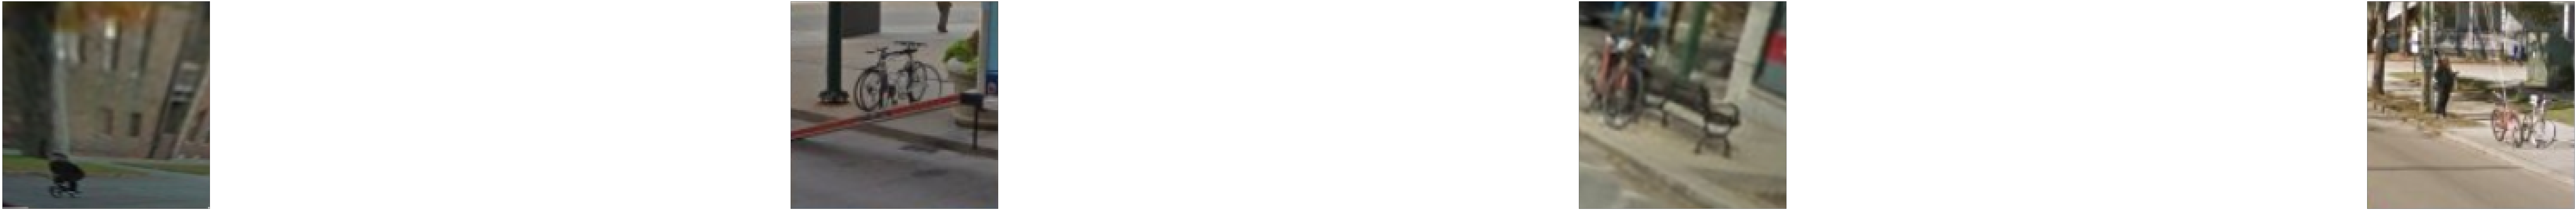

Bridge


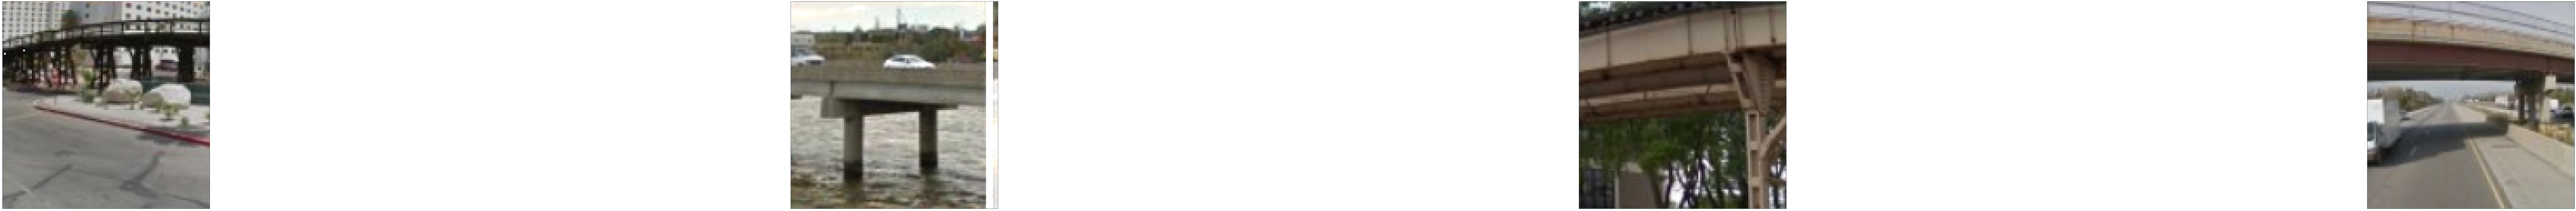

Bus


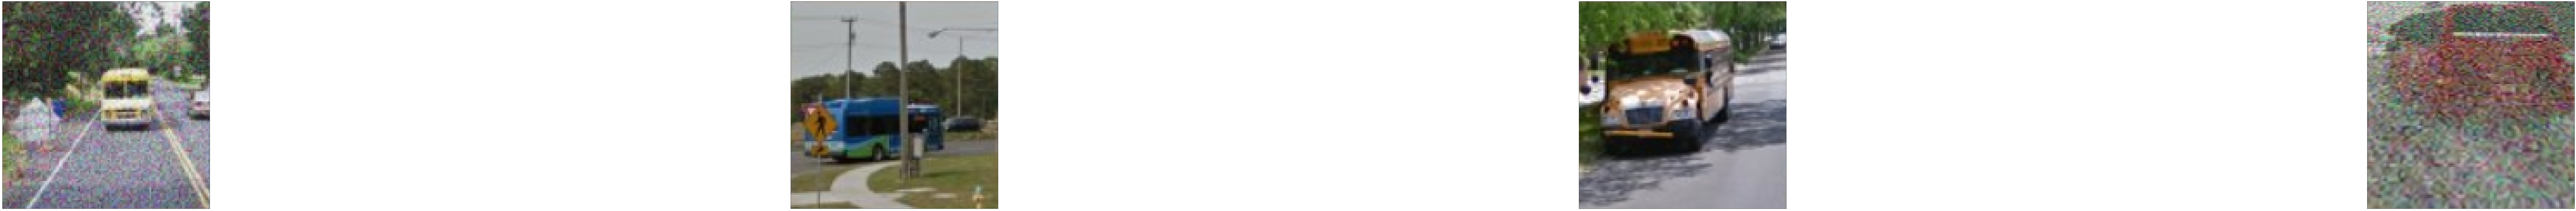

Car


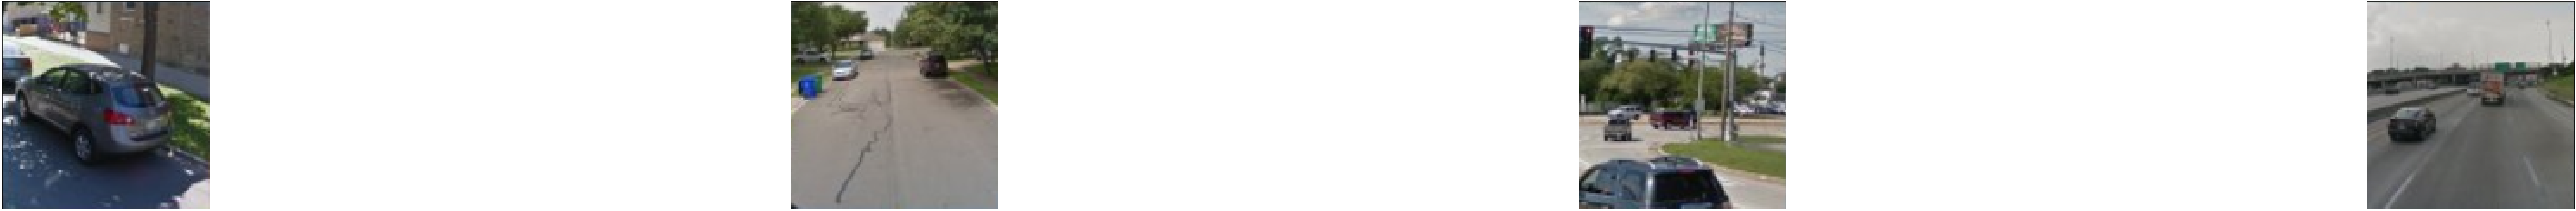

Chimney


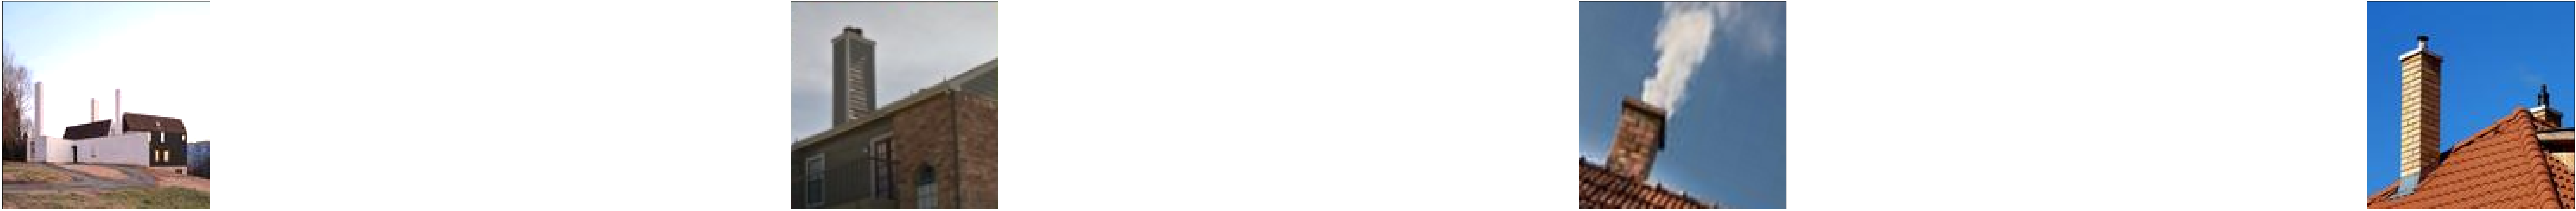

Crosswalk


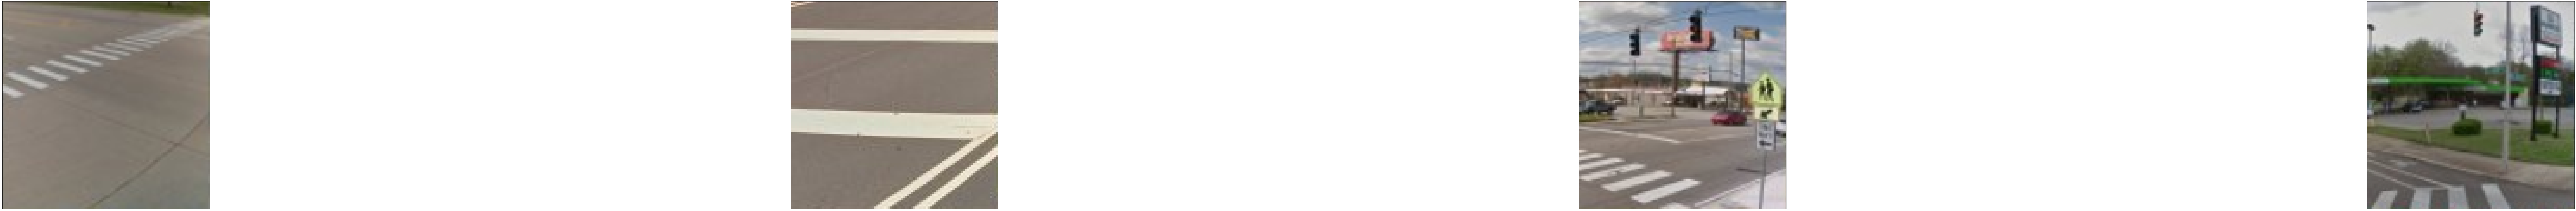

Hydrant


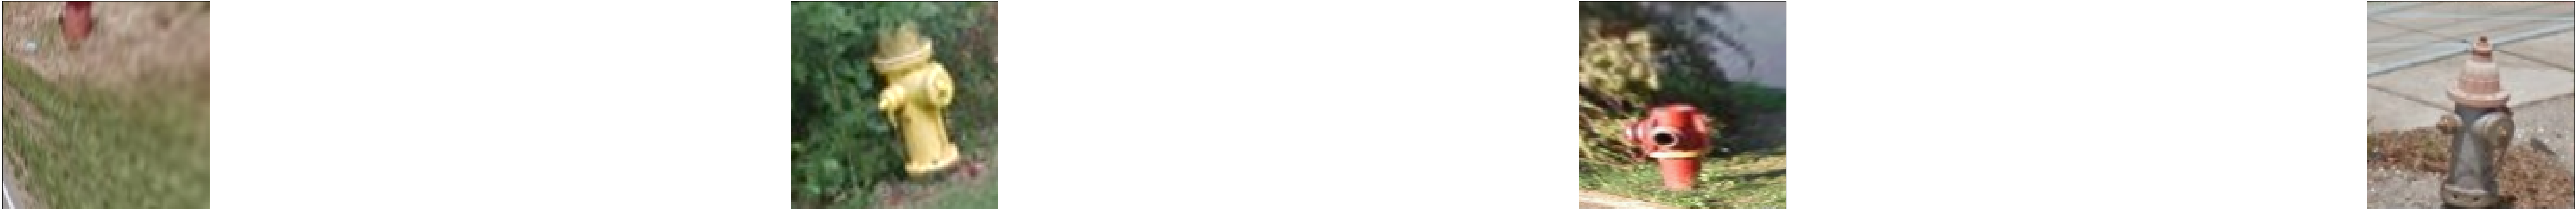

Motorcycle


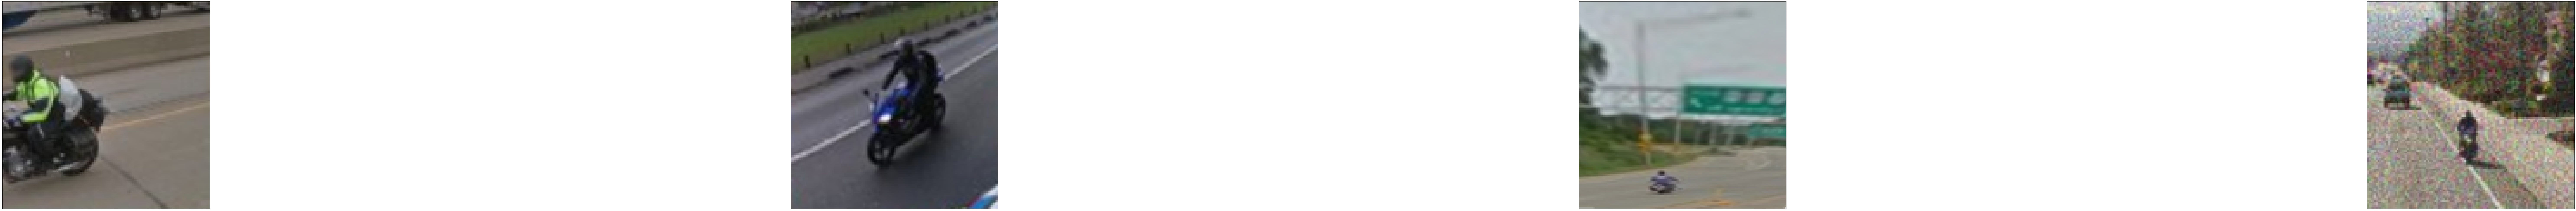

Other


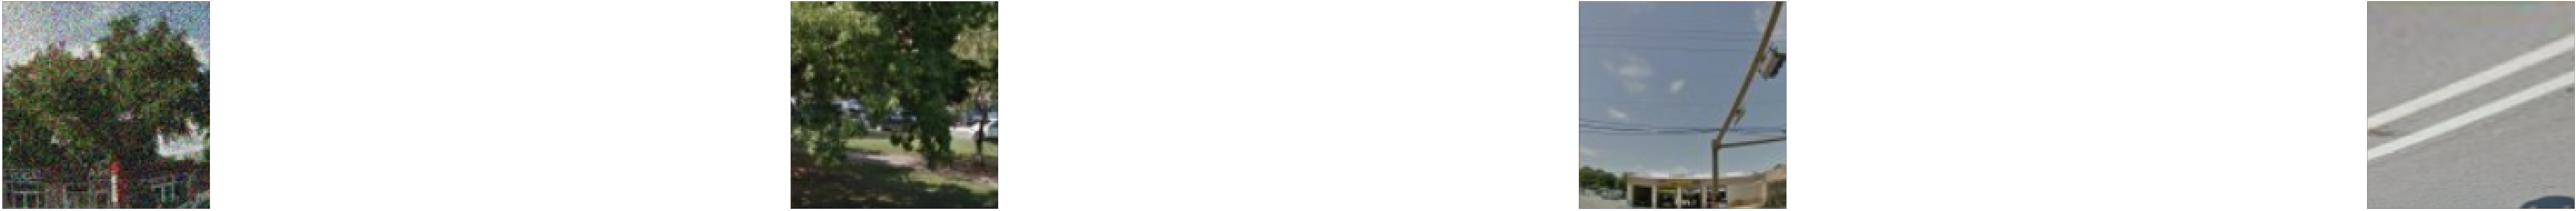

Palm


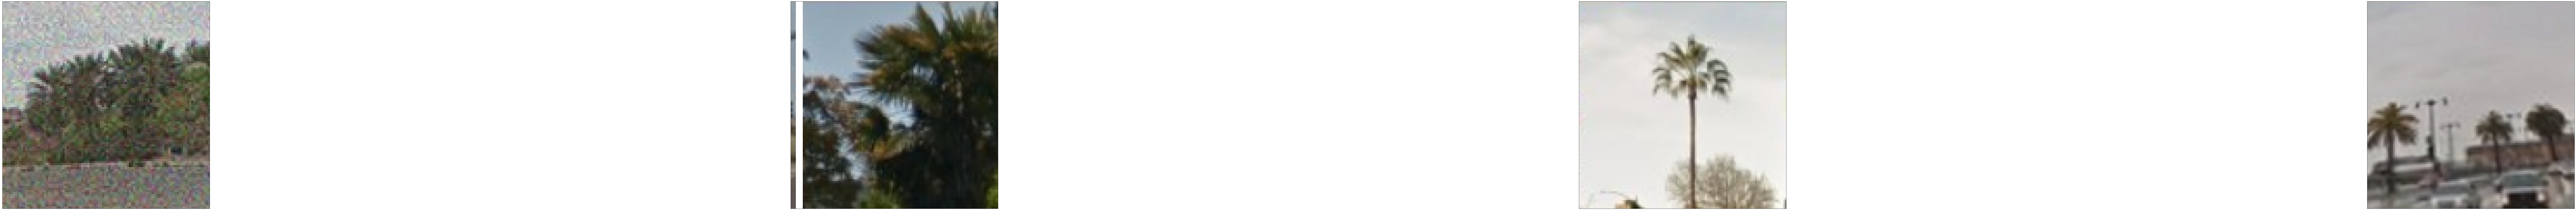

Stair


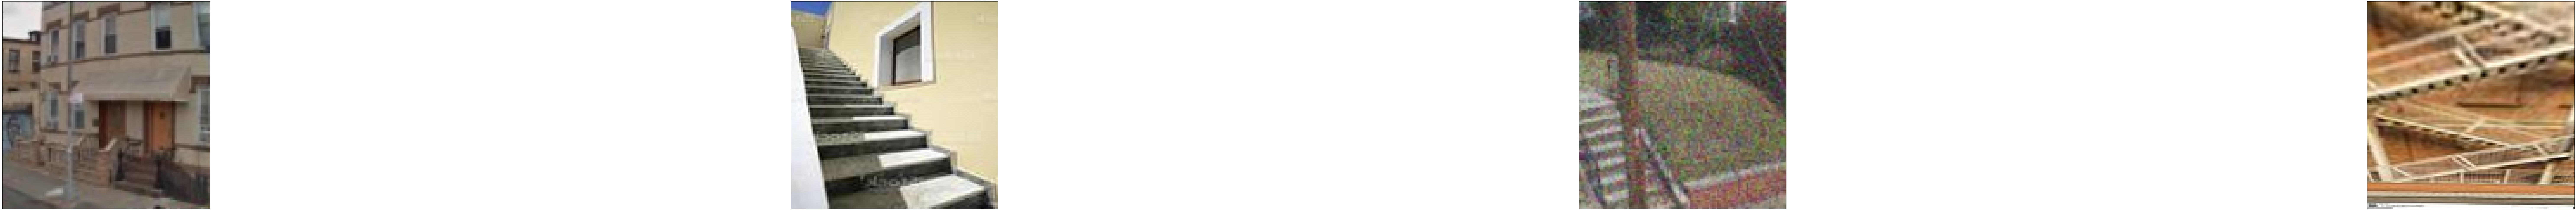

Traffic Light


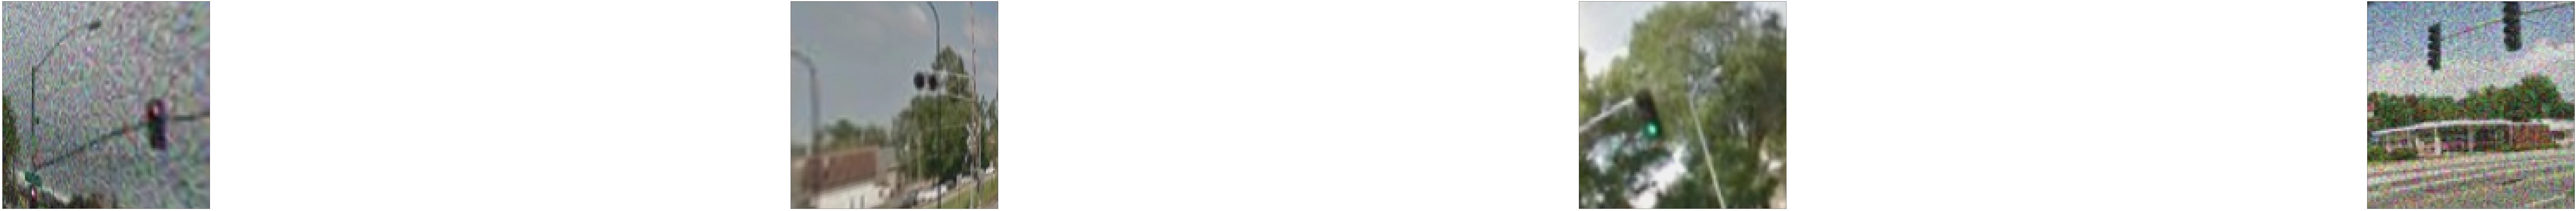

In [11]:
i = 0
for category in categories:
    category_path = os.path.join(BALANCED_DATASET_PATH, category, "")
    category_images = os.listdir(category_path)
    random_category_images = random.sample(category_images, 4)
    fig = plt.figure(num=category, figsize=(10, 10))
    fig.set_figwidth(250)
    fig.set_figheight(250)
    print(category)
    for category_image in random_category_images:
        plt.subplot(12, 4, i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        img = plt.imread(os.path.join(category_path, category_image))
        plt.imshow(img)
        i+=1
    plt.show()

### Making the model

In [12]:
IMG_WIDTH = 120
IMG_HEIGHT = 120
BATCH_SIZE = 64
NUM_CLASSES = len(categories)
RUNTIME_DIR = os.path.join(".", "Runtime", "")
TENSORBOARD_LOG_DIR = os.path.join(RUNTIME_DIR, "TensorBoard_Logs", "")

In [13]:
if not os.path.exists(RUNTIME_DIR):
    print(f"Making {RUNTIME_DIR}")
    os.mkdir(RUNTIME_DIR)

if not os.path.exists(TENSORBOARD_LOG_DIR):
    print(f"Making {TENSORBOARD_LOG_DIR}")
    os.mkdir(TENSORBOARD_LOG_DIR)

Making ./Runtime/
Making ./Runtime/TensorBoard_Logs/


In [14]:
training_images = tf.keras.utils.image_dataset_from_directory(
    BALANCED_DATASET_PATH,
    labels = "inferred",
    # label_mode = "int",
    validation_split = 0.3,
    subset = "training",
    shuffle = True,
    seed = 69,
    image_size = (IMG_HEIGHT, IMG_WIDTH),
    batch_size = BATCH_SIZE,
    color_mode = "rgb"
)

Found 25558 files belonging to 12 classes.
Using 17891 files for training.


In [15]:
validation_images = tf.keras.utils.image_dataset_from_directory(
    BALANCED_DATASET_PATH,
    labels = "inferred",
    color_mode = "rgb",
    image_size = (IMG_HEIGHT, IMG_WIDTH),
    batch_size = BATCH_SIZE,
    seed=69,
    shuffle = True,
    validation_split = 0.3,
    subset = "validation"
)

Found 25558 files belonging to 12 classes.
Using 7667 files for validation.


In [16]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.Resizing(height = IMG_HEIGHT, width = IMG_WIDTH),   # In case there are images with different dimentions
    tf.keras.layers.RandomFlip(mode = "horizontal"),
    tf.keras.layers.RandomRotation(factor = (-0.3, 0.3)),
#     tf.keras.layers.RandomContrast(factor = 0.2),
    tf.keras.layers.Rescaling(scale = 1./255),
])

In [17]:
AUTOTUNE = tf.data.AUTOTUNE

def cacheAndOptimizeDataset(dataset):
    dataset = dataset.map(
        lambda image, label: (data_augmentation(image), label), 
        num_parallel_calls = AUTOTUNE
    )
    dataset = dataset.cache(filename = RUNTIME_DIR)
    dataset = dataset.batch(BATCH_SIZE, num_parallel_calls = AUTOTUNE)
    dataset = dataset.shuffle(15000, reshuffle_each_iteration = True)
    dataset = dataset.prefetch(AUTOTUNE)
    
    return dataset

In [18]:
cacheAndOptimizeDataset(training_images)
cacheAndOptimizeDataset(validation_images)

<PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 120, 120, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, None), dtype=tf.int32, name=None))>

In [19]:
def makeModel(optimizer, lossFn, activationFn):    
    model = tf.keras.Sequential([
#         BATCH SIZE = 64
        tf.keras.layers.Conv2D(32, 3, padding = "same", input_shape = (IMG_WIDTH, IMG_HEIGHT, 3)),
        tf.keras.layers.BatchNormalization(),
        activationFn,
        tf.keras.layers.MaxPool2D(),
        tf.keras.layers.Conv2D(32, 3, padding = "same"),
        tf.keras.layers.BatchNormalization(),
        activationFn,
        tf.keras.layers.MaxPool2D(),
        tf.keras.layers.Conv2D(16, 3, padding = "same"),
        tf.keras.layers.BatchNormalization(),
        activationFn,
        tf.keras.layers.MaxPool2D(),

        tf.keras.layers.Flatten(),
        
        tf.keras.layers.Dense(64, activation = activationFn),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(32, activation = activationFn),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(16, activation = activationFn),
        tf.keras.layers.Dense(len(categories))
    ])
        
    model.compile(
        optimizer = optimizer,
        loss = lossFn,
        metrics=[tf.keras.metrics.SparseCategoricalAccuracy()]
    )

    return model

In [20]:
hyperparameters = [
    {"optimizer": "adam", "lossFn": tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), "activationFn": tf.keras.layers.ReLU()},
    {"optimizer": "adadelta", "lossFn": tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), "activationFn": tf.keras.layers.ReLU()},
    {"optimizer": "adagrad", "lossFn": tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), "activationFn": tf.keras.layers.ReLU()},
    {"optimizer": "rmsprop", "lossFn": tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), "activationFn": tf.keras.layers.ReLU()},
    {"optimizer": "sgd", "lossFn": tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), "activationFn": tf.keras.layers.ReLU()},
    {"optimizer": "rmsprop", "lossFn": tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), "activationFn": tf.keras.layers.LeakyReLU(alpha=0.2)},
    {"optimizer": "sgd", "lossFn": tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), "activationFn": tf.keras.layers.LeakyReLU(alpha=0.2)},
    {"optimizer": "adagrad", "lossFn": tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), "activationFn": tf.keras.layers.LeakyReLU(alpha=0.2)},
]
EPOCHS = 30
histories = []

for parameter in hyperparameters:
    tf.keras.backend.clear_session()
    
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~ HYPERPARAMETERS ~~~~~~~~~~~~~~~~~~~~~~~~~~~
    optimizer = parameter["optimizer"]
    loss_fn = parameter["lossFn"]
    activation_fn = parameter["activationFn"]
    
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~ GENERAL ~~~~~~~~~~~~~~~~~~~~~~~~~~~
    log_name = f"SSOC Google Recaptcha Img Classification - {optimizer}  loss:{loss_fn.name}  activation:{activation_fn.name}"
    print("~"*150)
    print(log_name)
    print("~"*150, end="\n\n")
    

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~ CALLBACKS ~~~~~~~~~~~~~~~~~~~~~~~~~~~
    current_timestamp = datetime.datetime.now().strftime('%d_%m_%y %I:%M:%S')
    tensorboard_callback = tf.keras.callbacks.TensorBoard(
        log_dir = os.path.join(TENSORBOARD_LOG_DIR, f"{optimizer}~{loss_fn.name}~{activation_fn.name}~{current_timestamp}"),  # this is the name of the folder for your current model
        histogram_freq = 1,
        write_graph = False
    )

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~ TRAINING ~~~~~~~~~~~~~~~~~~~~~~~~~~~
    model = makeModel(optimizer, loss_fn, activation_fn)
    
    history = model.fit(
        training_images,
        validation_data = validation_images,
        epochs = EPOCHS,
        batch_size = BATCH_SIZE,
        callbacks = [tensorboard_callback]
    )
    histories.append(history)
    
    print()
    print("~"*150)
    print()

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
SSOC Google Recaptcha Img Classification - adam  loss:sparse_categorical_crossentropy  activation:re_lu
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 1/30


2022-09-17 06:51:00.410208: W tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 11.0.221, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.


280/280 [==============================] - 105s 344ms/step - loss: 2.2663 - sparse_categorical_accuracy: 0.1956 - val_loss: 3.0641 - val_sparse_categorical_accuracy: 0.1473
Epoch 2/30
280/280 [==============================] - 25s 88ms/step - loss: 1.9875 - sparse_categorical_accuracy: 0.2970 - val_loss: 1.9582 - val_sparse_categorical_accuracy: 0.3176
Epoch 3/30
280/280 [==============================] - 25s 87ms/step - loss: 1.8772 - sparse_categorical_accuracy: 0.3378 - val_loss: 2.1236 - val_sparse_categorical_accuracy: 0.2675
Epoch 4/30
280/280 [==============================] - 25s 87ms/step - loss: 1.7909 - sparse_categorical_accuracy: 0.3626 - val_loss: 1.6888 - val_sparse_categorical_accuracy: 0.4047
Epoch 5/30
280/280 [==============================] - 24s 84ms/step - loss: 1.7242 - sparse_categorical_accuracy: 0.3900 - val_loss: 2.0833 - val_sparse_categorical_accuracy: 0.3332
Epoch 6/30
280/280 [==============================] - 24s 85ms/step - loss: 1.6667 - sparse_categor

In [ ]:
shutil.make_archive(base_name = os.path.join(".", "TensorboardLogs"), format="zip", root_dir = TENSORBOARD_LOG_DIR)

In [ ]:
# RUN this in console 
# NOTE - replace the <tensorboard_logs_dir> & <name> with your values
tensorboard dev upload --logdir "<tensorboard_logs_dir>" --name "<name>" --one_shot

In [ ]:
# CLEARING THE LOG DIRECTORY BEFORE RUNNING THE BELOW CELL
for directory in os.listdir(TENSORBOARD_LOG_DIR):
    possible_dir = os.path.join(TENSORBOARD_LOG_DIR, directory, "")
    if os.path.isdir(possible_dir):
        print(f"deleting {possible_dir}")
        shutil.rmtree(possible_dir)
os.remove(os.path.join(".", "TensorboardLogs.zip"))

In [21]:
histories = []
# Each conv2D layer will be accompined by a maxPool2D layer
EPOCHS = 20
BATCH_SIZE = 64
NUM_CLASSES = len(categories)
conv2D_layers = [3, 5]
conv2D_filters = [16, 32, 64]
dense_layers = [3, 5]
dense_neurons = [16, 32, 64]
# In total there will be 64(2x4x2x4) combinitions

for conv2D_layer_count in conv2D_layers:
    for conv2D_filter_count in conv2D_filters:
        for dense_layer_count in dense_layers:
            for dense_neuron_count in dense_neurons:
                tf.keras.backend.clear_session()
                log_name = f"c2DLayers={conv2D_layer_count} | c2DFilters={conv2D_filter_count} | denseLayers={dense_layer_count} | denseNeurons={dense_neuron_count}"
                print("~"*150)
                print(log_name)
                print("~"*150)
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
                model = tf.keras.Sequential()

                # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~ CONV & MAX_POOL Layers ~~~~~~~~~~~~~~~~~~~~~~~~~~~~ 
                for i in range(conv2D_layer_count):
                    model.add(tf.keras.layers.Conv2D(conv2D_filter_count, kernel_size=(3, 3), activation = tf.keras.layers.LeakyReLU(alpha=0.2)))
                    model.add(tf.keras.layers.MaxPool2D())

                model.add(tf.keras.layers.Flatten())

                # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~ DENSE ~~~~~~~~~~~~~~~~~~~~~~~~~~~~ 
                for i in range(dense_layer_count):
                    model.add(tf.keras.layers.Dense(dense_neuron_count, activation = tf.keras.layers.LeakyReLU(alpha=0.2)))
                    model.add(tf.keras.layers.Dropout(0.1))

                model.add(tf.keras.layers.Dense(NUM_CLASSES))
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

                # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~ DEFINING THE CALLBACKS ~~~~~~~~~~~~~~~~~~~~~~~~~~~~ 
                current_timestamp = datetime.datetime.now().strftime('%d_%m_%y %I:%M:%S')
                tensorboard_callback = tf.keras.callbacks.TensorBoard(
                    log_dir = os.path.join(TENSORBOARD_LOG_DIR, log_name),  # this is the name of the folder for your current model
                    histogram_freq = 1,
                    write_graph = False
                )

                model.compile(
                    optimizer = "rmsprop",
                    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                    metrics = ["sparse_categorical_accuracy"]
                )

                history = model.fit(
                    training_images,
                    validation_data = validation_images,
                    epochs = EPOCHS,
                    batch_size = BATCH_SIZE,
                    callbacks = [tensorboard_callback],
                )
                histories.append(history)

                print()
                print("~"*150)
                print()

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
c2DLayers=3 | c2DFilters=16 | denseLayers=3 | denseNeurons=16
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 1/20
280/280 [==============================] - 26s 87ms/step - loss: 2.7388 - sparse_categorical_accuracy: 0.1573 - val_loss: 2.2463 - val_sparse_categorical_accuracy: 0.2146
Epoch 2/20
280/280 [==============================] - 24s 85ms/step - loss: 2.1907 - sparse_categorical_accuracy: 0.2382 - val_loss: 2.0002 - val_sparse_categorical_accuracy: 0.2922
Epoch 3/20
280/280 [==============================] - 24s 85ms/step - loss: 2.0240 - sparse_categorical_accuracy: 0.2877 - val_loss: 1.8877 - val_sparse_categorical_accuracy: 0.3314
Epoch 4/20
280/280 [==============================] - 24s 85ms/step - loss: 1.9072 - spars

KeyboardInterrupt: 

In [ ]:
import os
from IPython.display import FileLink

shutil.make_archive(base_name = os.path.join(".", "TensorboardLogs"), format="zip", root_dir = TENSORBOARD_LOG_DIR)

# Run if on KAGGLE
FileLink(os.path.join(".", "TensorboardLogs.zip"))